# MVC project: Get the Data
- [GitHub](https://github.com/romainmartinez/mvc)

## 0. Setup

In [1]:
# Common imports
import pandas as pd
import numpy as np
import os

# the 'mvc' directory contains functions used but not necessary to understand the story
import mvc

# Figures
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sns.set_context("paper")

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 1. Load data

In [2]:
df = pd.read_hdf('mvc.h5')
df.head()

,upper trapezius,middle trapezius,lower trapezius,anterior deltoid,middle deltoid,posterior deltoid,pectoralis major,serratus anterior,latissimus dorsi,supraspinatus,...,8,9,10,11,12,13,14,15,max,best_test
0,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.104184,4
1,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.135626,1
2,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300761,2
3,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.262121,3
4,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.170468,2


## 2. Split the data

### Cross-Validation

In [3]:
from sklearn.model_selection import cross_val_score

In [4]:
def display_scores(scores):
    # we rectify the scores because cross_val_score expect a utility function (greater is better)
    # rather than a cost function (lower is better)
    scores_rectified = np.sqrt(-scores)
    print(f'Scores: {scores_rectified}')
    print(f'Mean: {scores_rectified.mean()}')
    print(f'STD: {scores_rectified.std()}')

### Stratified Train Test Split

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_labels = list(df.drop(['max', 'muscle', 'best_test'], axis=1).columns)
y_labels = ['max']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df[X_labels], df[y_labels], test_size=0.2, random_state=RANDOM_SEED,
                                       stratify=df['muscle'])

## 2. Feature importances with forests of trees

- We can use a Random Forest Regressor to evaluate the importance of features on an artificial regression task.

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [9]:
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

In [10]:
forest_reg = RandomForestRegressor(random_state=RANDOM_SEED)

In [11]:
n_iter_search = 100
random_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                   n_iter=n_iter_search, cv=5, random_state=RANDOM_SEED,
                                   scoring='neg_mean_squared_error')

In [12]:
random_search.fit(X_train, np.ravel(y_train))

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2ec33cf320>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2ec33cf470>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [13]:
random_search.best_params_

{'max_features': 7, 'n_estimators': 53}

In [15]:
features_importances = pd.DataFrame({'features': random_search.best_estimator_.feature_importances_},
                                    index=X_train.columns)
features_importances.sort_values(by='features', inplace=True)

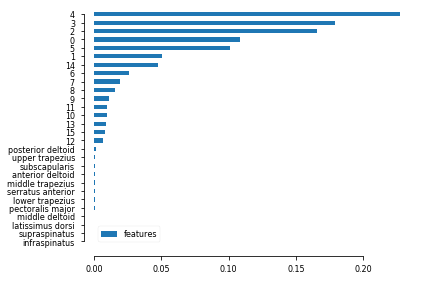

In [16]:
features_importances.plot(kind='barh')
sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.show()

#### Outcomes
- best three tests: 4, 3, 2
- best five tests: 4, 3, 2, 0, 5

## 3. Evaluate the model with all features

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

In [18]:
final_model = random_search.best_estimator_

final_predictions = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(f'final rmse: {final_rmse}')

final_variance = explained_variance_score(y_test, final_predictions)
print(f'explained variance: {final_variance}')

final_r2 = r2_score(y_test, final_predictions)
print(f'r2: {final_r2}')

final rmse: 0.04145145370352881
explained variance: 0.9515327889827369
r2: 0.9515216767221096
